## 1. Import and Install Dependencies

## 1.1 Install dependencies

In [ ]:
!pip install tensorflow tensorflow-gpu tensorflow-io==0.25.0 matplotlib

## 1.2 Load Dependencies

In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [2]:
# Avoid OOM (Out of Memory) errors by settings GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.3 Define Constants

In [3]:
PARSED_CAPUCHIN_BIRD_DIR = os.path.join('data', 'Parsed_Capuchinbird_Clips')
PARSED_NOT_CAPUCHIN_BIRD_DIR = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

## 2. Build Data Loading Function

## 2.1 Define Paths to Files

In [4]:
CAPUCHIN_FILE = os.path.join(PARSED_CAPUCHIN_BIRD_DIR, 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join(PARSED_NOT_CAPUCHIN_BIRD_DIR, 'afternoon-birds-song-in-forest-0.wav')

## 2.2 Build Dataloading Function

In [5]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    
    # Goes from 44100hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    
    return wav

In [6]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

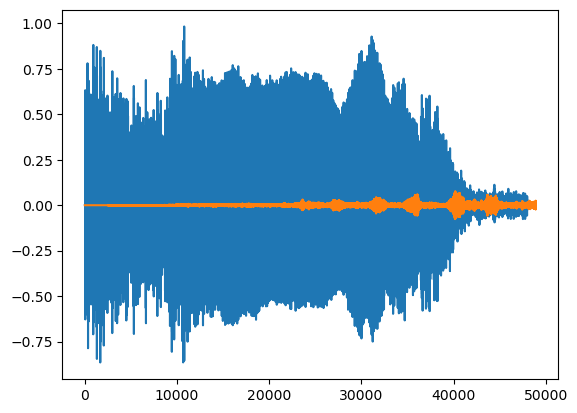

In [7]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

## 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [8]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

## 3.2 Create Tensorflow Datasets

In [9]:
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

In [10]:
pos.as_numpy_iterator().next()

b'data\\Parsed_Capuchinbird_Clips\\XC526106-3.wav'

## 3.3 Add labels And Combine Positive and Negative Sample

In [11]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [12]:
data.shuffle(1000).as_numpy_iterator().next()

(b'data\\Parsed_Capuchinbird_Clips\\XC216012-20.wav', 1.0)

## 4. Determine Average Length of a Capuchin Call

In [13]:
lengths = []
for file in os.listdir(PARSED_CAPUCHIN_BIRD_DIR):
    tensor_wave = load_wav_16k_mono(os.path.join(PARSED_CAPUCHIN_BIRD_DIR, file))
    lengths.append(len(tensor_wave))

In [14]:
mean = tf.math.reduce_mean(lengths)
print(80000 / mean)

tf.Tensor(1.4772139744441983, shape=(), dtype=float64)


In [15]:
min = tf.math.reduce_min(lengths)
print(80000 / min)

tf.Tensor(2.5, shape=(), dtype=float64)


In [16]:
max = tf.math.reduce_max(lengths)
print(80000 / max)

tf.Tensor(1.0, shape=(), dtype=float64)


## 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [17]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    
    spectrogram = tf.signal.stft(wav, frame_length=160, frame_step=64)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    
    return spectrogram, label

## 5.2 Test Out the Function and Viz the Spectrogram

In [18]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [19]:
spectrogram, label = preprocess(filepath, label)

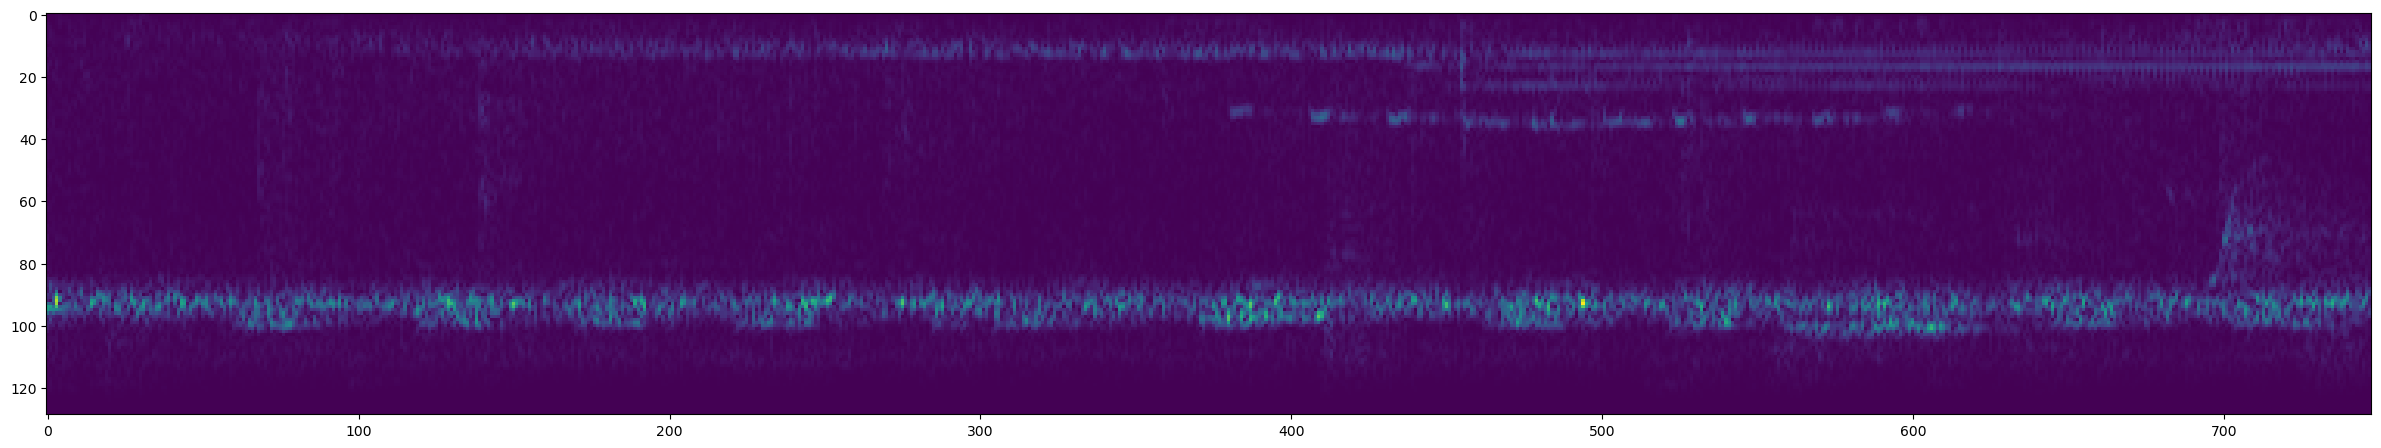

In [20]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

## 6. Create Traning and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [21]:
preprocessed_data = data.map(preprocess)
cached_data = preprocessed_data.cache()
shuffled_data = cached_data.shuffle(buffer_size=1000)
batched_data = shuffled_data.batch(16)
prefetched_data = batched_data.prefetch(8)

## 6.2 Split into Training and Testing Partitions

In [22]:
len(prefetched_data)*.7

35.699999999999996

In [23]:
train = prefetched_data.skip(36)
test = prefetched_data.skip(36).take(15)

## 6.3 Test One Batch

In [24]:
samples, labels = train.as_numpy_iterator().next()

In [25]:
samples.shape

(16, 748, 129, 1)

In [26]:
labels

array([0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.],
      dtype=float32)

## 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [27]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, Dense, Flatten, BatchNormalization, MaxPooling2D, Dropout
from tensorflow.keras.regularizers import l2

In [28]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(748, 129, 1), kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [29]:
recall_callback = tf.keras.metrics.Recall()
precision_callback = tf.keras.metrics.Precision()

model.compile("Adam", loss="BinaryCrossentropy", metrics=[recall_callback, precision_callback])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 746, 127, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 746, 127, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 373, 63, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 371, 61, 64)       18496     
                                                                 
 batch_normalization_1 (Batc  (None, 371, 61, 64)      256       
 hNormalization)                                                 
                                                        

In [31]:
hist = model.fit(train, epochs=60, validation_data=test)

Epoch 1/60
15/15 [==============================] - 8s 131ms/step - loss: 29.3721 - recall: 0.7966 - precision: 0.6026 - val_loss: 3.3991 - val_recall: 0.8481 - val_precision: 0.9178
Epoch 2/60
15/15 [==============================] - 1s 84ms/step - loss: 7.2638 - recall: 0.7460 - precision: 0.8868 - val_loss: 3.2233 - val_recall: 0.7647 - val_precision: 0.8125
Epoch 3/60
15/15 [==============================] - 1s 84ms/step - loss: 4.1869 - recall: 0.6364 - precision: 0.8974 - val_loss: 3.9992 - val_recall: 0.8214 - val_precision: 0.8214
Epoch 4/60
15/15 [==============================] - 1s 84ms/step - loss: 4.5840 - recall: 0.6949 - precision: 0.8723 - val_loss: 3.3390 - val_recall: 0.9048 - val_precision: 0.8382
Epoch 5/60
15/15 [==============================] - 1s 84ms/step - loss: 4.5385 - recall: 0.9180 - precision: 0.8750 - val_loss: 3.9682 - val_recall: 0.8364 - val_precision: 0.8846
Epoch 6/60
15/15 [==============================] - 1s 84ms/step - loss: 4.4307 - recall: 0.7

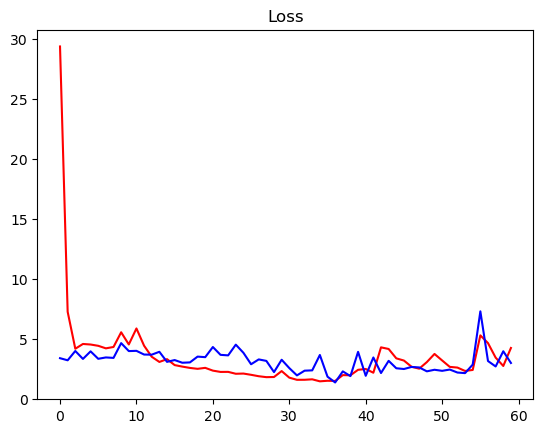

In [32]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [33]:
# hist.history

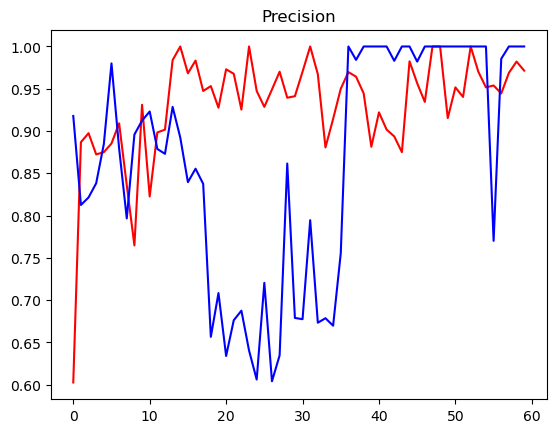

In [34]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

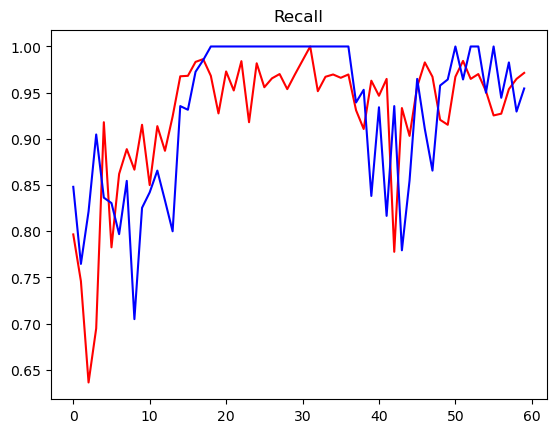

In [35]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

## 8. Make a Prediction on a Single Clip

## 8.1  Get One Batch and Make a Prediction

In [36]:
X_test, y_test = test.as_numpy_iterator().next()

In [37]:
y_test.shape

(16,)

In [38]:
yhat = model.predict(X_test)

In [39]:
yhat

array([[0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [1.000000e+00],
       [1.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [1.000000e+00],
       [0.000000e+00],
       [8.726994e-13],
       [0.000000e+00],
       [1.000000e+00],
       [0.000000e+00],
       [0.000000e+00]], dtype=float32)

## 8.2 Convert Logits to classes

In [40]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

## 9. Build Forest Parsing Functions

In [41]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [42]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=5.0>

## 9.1 Load up MP3s

In [43]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16khz single-channel """
    res = tfio.audio.AudioIOTensor(filename)
    
    # Convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    
    # Extract the sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    
    # Resample to 16khz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [44]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [45]:
wav = load_mp3_16k_mono(mp3)

In [46]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [47]:
samples, index = audio_slices.as_numpy_iterator().next()

In [48]:
len(audio_slices)

60

In [49]:
samples.shape

(1, 48000)

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [50]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample], 0)
    
    spectrogram = tf.signal.stft(wav, frame_length=160, frame_step=64)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    
    return spectrogram

## 9.3 Convert Longer Clips to Windows and Make Predictions

In [51]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [52]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [53]:
yhat

[0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

## 9.4 Group Consecutive Detections

In [54]:
from itertools import groupby

In [55]:
yhat = [key for key, group in groupby(yhat)]

In [56]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [57]:
calls = tf.math.reduce_sum(yhat).numpy()

In [58]:
calls

5

# 10. Make Predictions

In [59]:
results = {}
for file in os.listdir(os.path.join("data", "Forest Recordings")):
    FILE_PATH = os.path.join("data", "Forest Recordings", file)
    
    wav = load_mp3_16k_mono(FILE_PATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

In [ ]:
results

## 10.2 Convert Predictions into Classes

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.5 else 0 for prediction in logits]
class_preds

## 10.3 Group Consecutive Detections

In [63]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 21,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 5,
 'recording_17.mp3': 3,
 'recording_18.mp3': 5,
 'recording_19.mp3': 1,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_24.mp3': 0,
 'recording_25.mp3': 15,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_28.mp3': 11,
 'recording_29.mp3': 0,
 'recording_30.mp3': 3,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_33.mp3': 0,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_36.mp3': 0,
 'recording_37.mp3': 3,
 'recording_38.mp3': 1,
 'recording_39.mp3': 16,
 'recording_40.mp3': 1,
 'recording_

In [64]:
import csv

In [68]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    
    for key, value in postprocessed.items():
        writer.writerow([key, value])